# Phase 1 with plots and figures removed to improve readability
Phase 2 starts on card 25

In [1]:
import pandas as pd
from sklearn import tree


data = pd.read_csv("https://github.com/Brunel-Visualization/Brunel/raw/master/python/examples/data/whiskey.csv")


In [2]:
Rating = len(data) - data['Rating'].count()
print("Missing value of rating = ", Rating)

Missing value of rating =  11


In [3]:
Price = len(data) - data['Price'].count()
print("Missing value of price = ", Price)

Missing value of price =  4


In [4]:
ABV = len(data) - data['ABV'].count()
print("Missing value of ABV = ", ABV)

Missing value of ABV =  13


In [5]:
Age = len(data) - data['Age'].count()
print("Missing value of age = ", Age)

Missing value of age =  109


In [6]:
 ##data = data.drop('Rating', 1)

In [7]:
 data['Rating'] = data['Rating'].fillna(data['Rating'].mode()[0])

In [8]:
data['Price'] = data['Price'].fillna(data['Price'].mode()[0])

In [9]:
data['ABV'] =  data['ABV'].fillna(data['ABV'].mean())

In [10]:
data['Age'] =  data['Age'].fillna(data['Age'].mode()[0])

## Task 3

#### – Investigate outlier(s): for each numeric attribute, perform IQR method to detect outlier.

In [11]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Rating    12.0
Price     49.5
ABV        6.0
Age        3.0
dtype: float64


#### Find the outlier using function
#### The function return a boolean vector: True if the element is an outlier. False, otherwise.

In [12]:
import numpy as np   # to manipulate arrays

# a number "a" from the vector "x" is an outlier if 
# a > median(x)+1.5*iqr(x) or a < median-1.5*iqr(x)
# iqr: interquantile range = third interquantile - first interquantile
def outliers(x): 
       return np.abs(x- x.median()) > 1.5*(x.quantile(.75)-x.quantile(0.25))

# Give the outliers for the first column for example
#outliers(data['Price'])

In [13]:
#outliers(data['ABV'])

In [14]:
#outliers(data['Age'])

## Task6 && Task7

In [15]:
data.dtypes

Name         object
Rating      float64
Country      object
Category     object
Price       float64
ABV         float64
Age         float64
Brand        object
dtype: object

In [16]:
from sklearn.decomposition import PCA

df = data[['Rating', 'Price',  'Age', 'ABV']]

pca = PCA(n_components=2, svd_solver='full')
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [17]:
T = pca.transform(df)

In [18]:
components = pd.DataFrame(pca.components_, columns = df.columns, index=[1, 2])
components

,Rating,Price,Age,ABV
1,0.038566,0.998596,0.035921,0.005232
2,-0.988946,0.040475,-0.043658,-0.135803


In [19]:
import math

def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print( "Features by importance:\n", important_features)

get_important_features(T, pca.components_, df.columns.values)

Features by importance:
 [(776.3701237438903, 'Price'), (51.428180626750695, 'Rating'), (27.988045719263262, 'Age'), (7.03350764976869, 'ABV')]


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def draw_vectors(transformed_features, components_, columns):
    """
    This funtion will project your *original* features
    onto your principal component feature-space, so that you can
    visualize how "important" each one was in the
    multi-dimensional scaling
    """

    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ax = plt.axes()

    for i in range(num_columns):
    # Use an arrow to project each original feature as a
    # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75)

    return ax

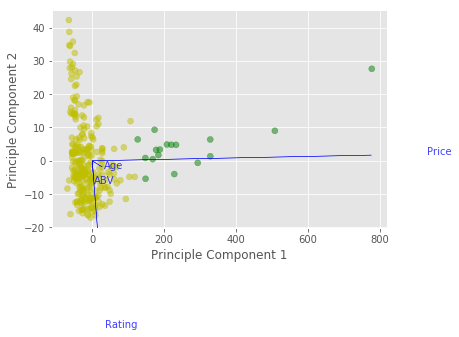

In [21]:
ax = draw_vectors(T, pca.components_, df.columns.values)
T_df = pd.DataFrame(T)
T_df.columns = ['component1', 'component2']

T_df['color'] = 'y'
T_df.loc[T_df['component1'] > 125, 'color'] = 'g'
T_df.loc[T_df['component2'] > 125, 'color'] = 'r'

plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.scatter(T_df['component1'], T_df['component2'], color=T_df['color'], alpha=0.5)
plt.show()

In [22]:
def change_Labels(x):
    
    if x>=40 and x<=60:
        return 'Low'
    if x>=61 and x<=80:
        return 'Medium'
    if x>=81 and x<=100:
        return 'High'

In [23]:
data['Rating'] = data['Rating'].apply(change_Labels)

### PCA

In [24]:
data['Rating'].value_counts()

High      213
Medium     53
Low        17
Name: Rating, dtype: int64

In [25]:
data.corr()

,Price,ABV,Age
Price,1.000000,0.074832,0.588755
ABV,0.074832,1.000000,-0.029453
Age,0.588755,-0.029453,1.000000


# Phase 2 - CART classification

In [26]:
# prepare data for classification
    # brands will be converted to integers
brands = {}
counter = 0
for brand in data['Brand']:
    if brand not in brands:
        brands[brand] = counter
        counter+=1
for x in range(len(data['Brand'])):
    data['Brand'][x]=brands[data['Brand'][x]]

C:\Users\SIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [27]:
# nominal attributes will also be converted to integers
for col in ['Name','Rating','Country','Category']:
    data[col] = data[col].astype('category')

In [28]:
cat_columns = data.select_dtypes(['category']).columns
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
data[1:5]

,Name,Rating,Country,Category,Price,ABV,Age,Brand
1,64,1,0,0,10.0,44.610444,12.0,1
2,175,1,4,0,20.0,40.000000,12.0,2
3,231,1,0,0,10.0,44.610444,12.0,3
4,66,1,0,0,12.0,40.000000,12.0,4


In [29]:
from sklearn import tree

In [30]:
# prepare a dataset named 'whiskeys' to use in classification
whiskeys={'data':[], 'target':[], 'target_names':[]}
for target_name in brands.keys():
    whiskeys['target_names'].append(target_name)
for x in range(len(data['Brand'])):
    temp_arr = [data['Rating'][x], data['Country'][x], data['Category'][x], data['Price'][x], data['ABV'][x], data['Age'][x]]
    whiskeys['data'].append(temp_arr)
    whiskeys['target'].append(data['Brand'][x])

In [31]:
# separate training data from testing data
from random import randint
test_whiskeys = {'data':[], 'target':[], 'target_names':[]}
#                     20% of data is used
for x in range(round(len(whiskeys['data'])*0.2)):    
    perform_cut = 0
    while perform_cut != 1:
        cut_index = randint(0, len(whiskeys['data'])-1) # choose random whiskey for training set
        target_brand = whiskeys['target'][cut_index]
        target_count = 0
        for brand in whiskeys['target']:
            if brand == target_brand:
                target_count += 1
        # only remove a whiskey from dataset if there will be more left from the same brand afterwards 
        if target_count >2: 
            perform_cut = 1

    test_whiskeys['data'].append(whiskeys['data'].pop(cut_index))
    target = whiskeys['target'].pop(cut_index)
    test_whiskeys['target'].append(target)
    if target not in test_whiskeys['target_names']:
        test_whiskeys['target_names'].append(target)
    

In [32]:
# train classifier on dataset
clf = tree.DecisionTreeClassifier()
clf = clf.fit(whiskeys['data'], whiskeys['target'])

In [33]:
import seaborn
# make the prediction on the test data
prediction = clf.predict(test_whiskeys['data'])

In [46]:
score = 0
for x in range(len(prediction)):
    if prediction[x] == test_whiskeys['target'][x]:
        score+=1
right = score
score = score/len(prediction)*100
score = [round(score, 2), right, len(prediction)]

In [35]:
# add target brands inferred by the DT but were not originally in the testing set
for x in prediction:
    if x not in test_whiskeys['target_names']:
        test_whiskeys['target_names'].append(x)
test_whiskeys['target_names'].sort()

## task 2 - confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix
# create confusion matrix from test set and prediction based on the desired lables(brands)
cm = confusion_matrix(test_whiskeys['target'], prediction, test_whiskeys['target_names'])

In [37]:
# find real brand names as labels for the confusion matrix
for index, brand in enumerate(test_whiskeys['target_names']):
    brand_name = [k for k,v in brands.items() if v == brand][0]
    test_whiskeys['target_names'][index] = brand_name
test_whiskeys['target_names'][0]

'Canadian Club'

In [38]:
# function from https://gist.github.com/nickynicolson/202fe765c99af49acb20ea9f77b6255e
# it converts the confusion matrix to a dataframe and adds the labels
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

cm = cm2df(cm, test_whiskeys['target_names'])
#cm

In [47]:
#print('Final score is '+str(round(score,2))+"%")
print('Final score is '+str(score[0])+"%. With "+str(score[1])+" right predictions out of "+str(score[2]))

Final score is 26.32%. With 15 right predictions out of 57


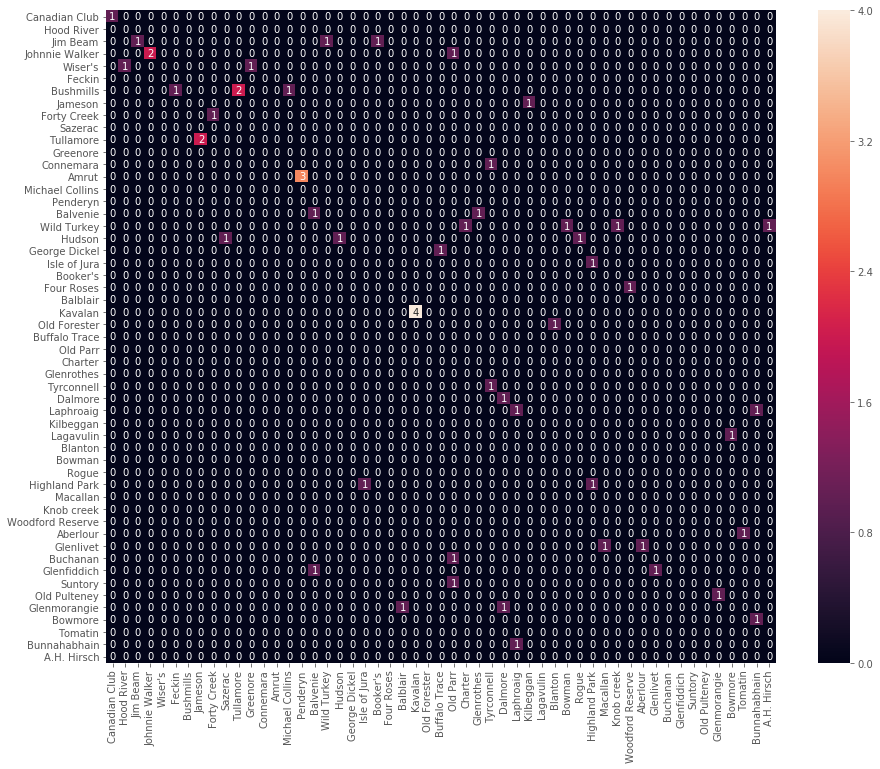

In [40]:
plt.figure(figsize = (15,12))
seaborn.heatmap(cm, annot=True)

In [41]:
# run a prediction on the training data and create confusion matrix
# comparing the 2 I would say we clearly have an overfitting problem
cm = confusion_matrix(whiskeys['target'], clf.predict(whiskeys['data']))

In [42]:
cm = cm2df(cm, whiskeys['target_names'])

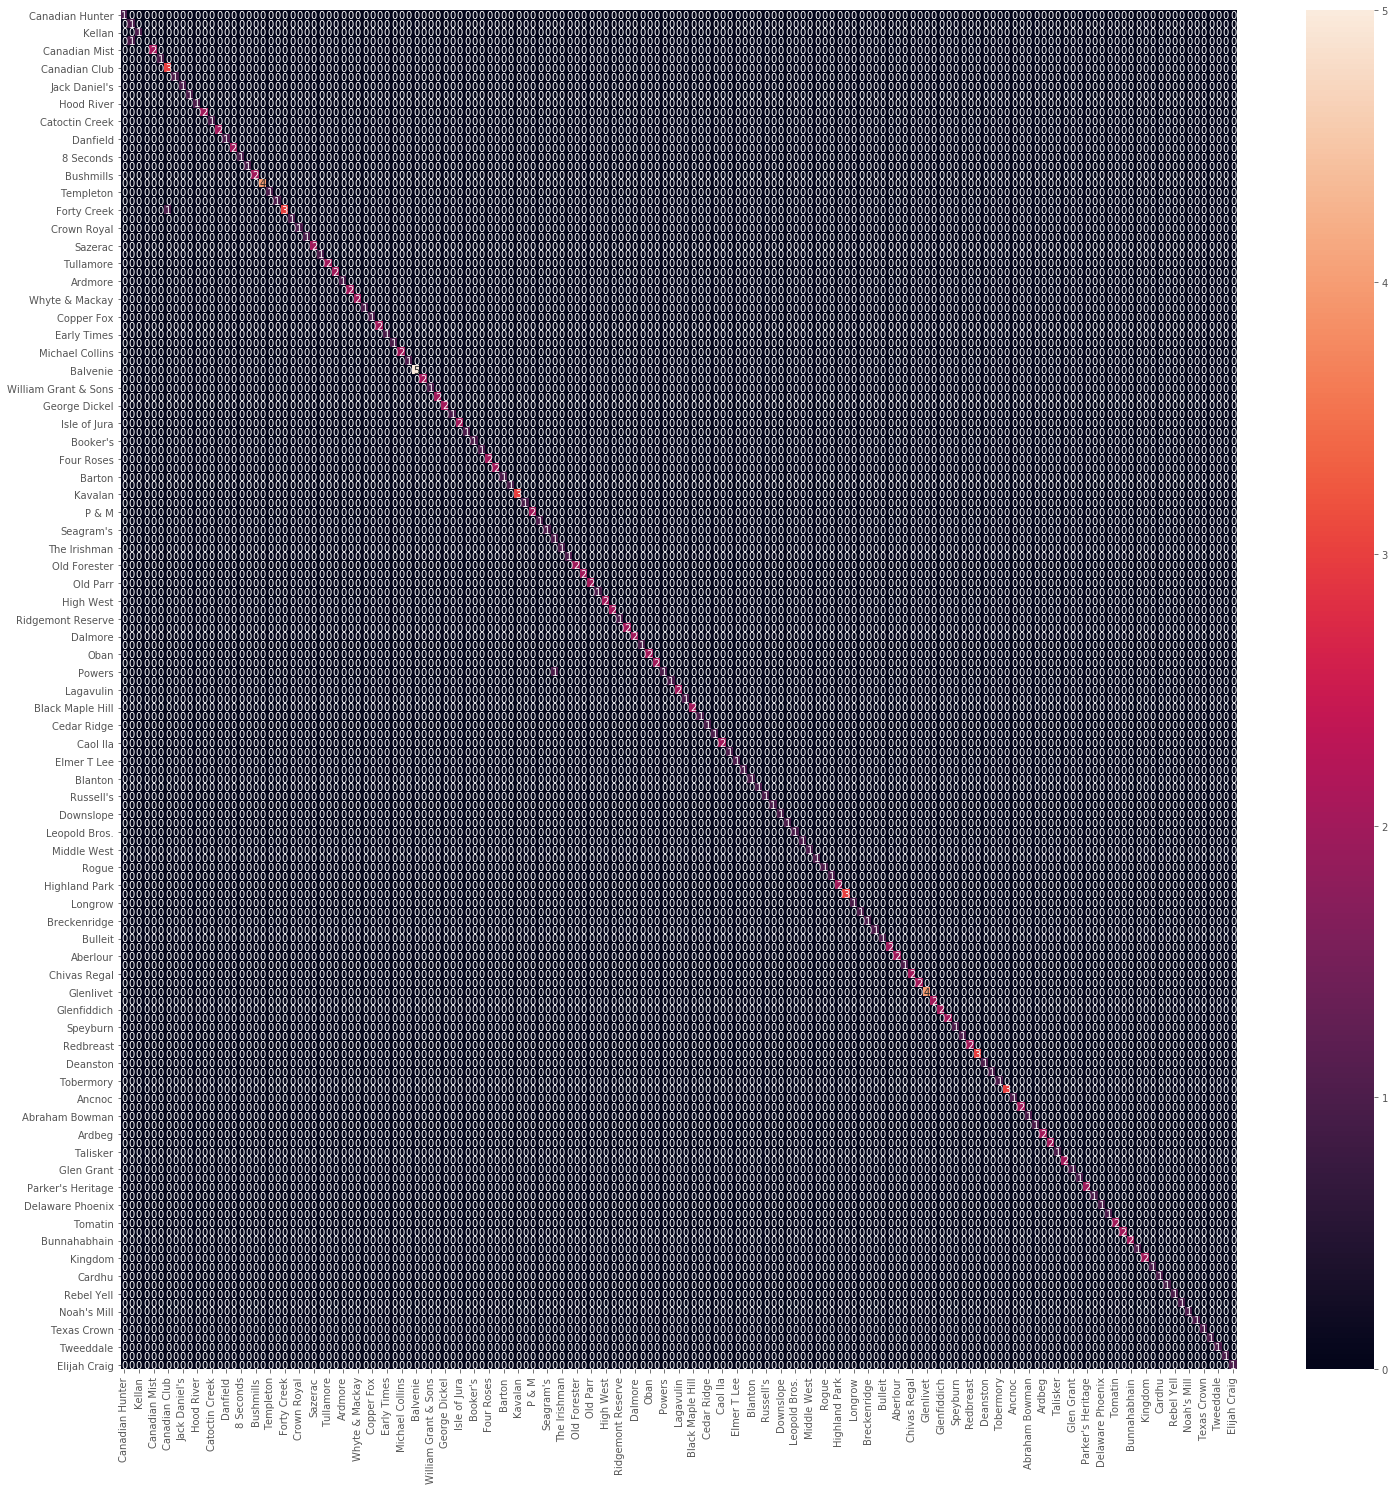

In [43]:
plt.figure(figsize = (25,25))
# plt.figure(figsize = (50,50)) #if you want to view this picture, save it first
seaborn.heatmap(cm, annot=True)